In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler, ConcatDataset
import os
from PIL import Image, ImageEnhance
import pandas as pd
import random
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import matplotlib.pyplot as plt
import numpy as np

"""
The goal of this code is to classify sattelite imagery of based on land cover
Because the datasets are collated from two distinct sources, a whiteness filter to mimic haze/ clouds
only found in the uncorrected portion of the dataset is applied
A convolutional neural network (pre-trained resnet50) is updated and aplied to the imagery
"""

class LandCoverDataset(Dataset):
    def __init__(self, csv, transform):
        self.data = pd.read_csv(csv)
        self.csv = csv
        self.transform = transform
        self.data['tags'] = self.data['tags'].apply(self.adjust_label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if idx >= len(self.data):
            raise StopIteration("No more items to retrieve")
        image_name = self.data.loc[idx, 'image_name']
        if 'img' in image_name:
            image_name = image_name[:-8]
        image_name += ".jpg"
        image_path_1 = os.path.join('/Users/trevor/Desktop/Subjects/1.C51ML/archive/planet/planet/train-jpg/', image_name)
        image_path_2 = os.path.join('/Users/trevor/Desktop/Subjects/1.C51ML/widsdatathon2019/train_images/', image_name)
    
        # Attempt to open the image from the first directory
        try:
            image = Image.open(image_path_1)
        except FileNotFoundError:
            # If the image is not found in the first directory, attempt to open from the second directory
            try:
                image = Image.open(image_path_2)
            except FileNotFoundError:
                print(f"Image {image_name} not found in either directory.")
                return self.__getitem__(idx + 1)
        
        # Apply transformations
        if self.data.loc[idx, 'tags'] == 'oil_palm':
            # Randomly apply whitening filter with different levels of whiteness
            #whiteness_level = random.uniform(0.25, 1.5)  # Adjust the range based on your preference
            #image = ImageOps.equalize(image, mask=None)  # Apply whitening filter
            #image = ImageEnhance.Brightness(image).enhance(whiteness_level)  # Adjust brightness
            overlay = Image.new('RGB', image.size, (255, 255, 255))
            # Set the opacity of the overlay (0 for fully transparent, 255 for fully opaque)
            opacity = random.uniform(65, 100)
            # Blend the overlay with the image
            image = Image.blend(image, overlay, opacity/255 )
            
        image = self.transform(image)  
        label = self.data.loc[idx, 'tags']
        adjusted_label = self.adjust_label(label)
        return {'image': image, 'labels': adjusted_label}

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        if idx >= len(self.data):
            raise StopIteration("No more items to retrieve")
        image_name = self.data.loc[idx, 'image_name']
        if 'img' in image_name:
            image_name = image_name[:-8]
        image_name += ".jpg"
        image_path_1 = os.path.join('/Users/trevor/Desktop/Subjects/1.C51ML/archive/planet/planet/train-jpg/', image_name)
        image_path_2 = os.path.join('/Users/trevor/Desktop/Subjects/1.C51ML/widsdatathon2019/train_images/', image_name)
    
        # Attempt to open the image from the first directory
        try:
            image = Image.open(image_path_1)
        except FileNotFoundError:
            # If the image is not found in the first directory, attempt to open from the second directory
            try:
                image = Image.open(image_path_2)
            except FileNotFoundError:
                print(f"Image {image_name} not found in either directory.")
                return self.__getitem__(idx + 1)
        # Apply transformations
        image = self.transform(image)  
        label = self.data.loc[idx, 'tags']
        adjusted_label = self.adjust_label(label)
        return {'image': image, 'labels': adjusted_label}

    def adjust_label(self, label):
        if 'selective_logging' in label:
            return 'selective_logging'
        elif 'agriculture' in label or 'cultivation' in label:
            return 'agriculture'
        elif 'habitation' in label:
            return 'habitation'
        elif 'blow_down' in label:
            return 'blow_down'
        elif 'road' in label:
            return 'road'
        elif 'primary' in label:
            return 'primary'
        elif 'oil_palm' in label:
            return 'oil_palm'
        else:
            return 'other'

    def subset(self, labels):
        # Note that this irreversibly changes the input-- that is ok for my application
        self.data = self.data[self.data['tags'].isin(labels)]
        self.data.reset_index(drop=True, inplace = True)
        return self
        
    def print_labels(self):
        print(self.data['tags'].unique())


In [55]:
mlaa_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Lambda(lambda img: img.convert('RGB')),  
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [56]:
trainlabels = '/Users/trevor/Desktop/Subjects/1.C51ML/finalproj/shuffledtrain.csv'
testlabels = '/Users/trevor/Desktop/Subjects/1.C51ML/finalproj/shuffledtest.csv'
trainingDataset = LandCoverDataset(trainlabels, mlaa_transform)
testingDataset = LandCoverDataset(testlabels, mlaa_transform)

In [57]:
first = trainingDataset[4000]
print(first)

{'image': tensor([[[-1.9124, -1.8097, -1.7925,  ..., -1.7412, -1.7754, -1.7240],
         [-1.7925, -1.7754, -1.7925,  ..., -1.7240, -1.7754, -1.7754],
         [-1.7754, -1.8097, -1.8268,  ..., -1.7240, -1.7754, -1.8097],
         ...,
         [-1.3987, -1.5699, -1.6384,  ..., -1.9809, -1.9809, -1.9124],
         [-1.3130, -1.5528, -1.6213,  ..., -1.9124, -1.9467, -1.8782],
         [-1.2788, -1.5185, -1.6042,  ..., -1.8782, -1.9124, -1.8610]],

        [[-1.6155, -1.5280, -1.5630,  ..., -1.4755, -1.5105, -1.4580],
         [-1.5455, -1.4930, -1.5630,  ..., -1.4755, -1.5280, -1.5105],
         [-1.5105, -1.5105, -1.5805,  ..., -1.4930, -1.5280, -1.5630],
         ...,
         [-1.2654, -1.3529, -1.4055,  ..., -1.7556, -1.7381, -1.6331],
         [-1.1779, -1.3179, -1.4055,  ..., -1.7206, -1.7381, -1.6331],
         [-1.1253, -1.2829, -1.3880,  ..., -1.7031, -1.7381, -1.6681]],

        [[-1.5430, -1.4907, -1.4733,  ..., -1.4733, -1.5256, -1.4907],
         [-1.4907, -1.4559, -1.4733

In [58]:
training = trainingDataset.subset(['primary', 'road', 'selective_logging', 'oil_palm'])  
testing = testingDataset.subset(['primary', 'road', 'selective_logging', 'oil_palm'])  

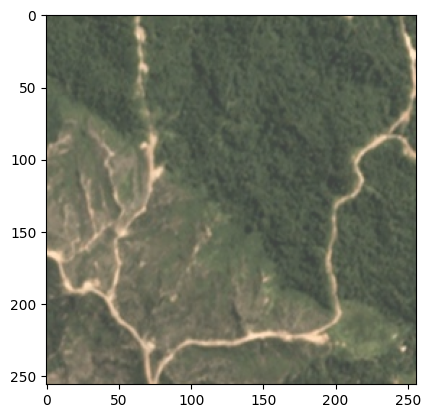

In [53]:
image = Image.open('/Users/trevor/Desktop/Subjects/1.C51ML/widsdatathon2019/train_images/img_02462.jpg')
overlay = Image.new('RGB', image.size, (255, 255, 255))
# Set the opacity of the overlay (0 for fully transparent, 255 for fully opaque)
opacity = 65#random.uniform(50, 100)
# Blend the overlay with the image
result = Image.blend(image, overlay, opacity/255 )
plt.imshow(result)

In [59]:
batch_size = 32
train_loader = DataLoader(training, batch_size=batch_size, shuffle = True)
val_loader = DataLoader(testing, batch_size = batch_size)

In [61]:
resnet50Trained = models.resnet50(weights= 'ResNet50_Weights.DEFAULT')
resnet50Trained.fc = nn.Linear(in_features=2048, out_features=4, bias=True)

In [62]:
# Initialize counters for each group
group_counts = {'primary': 0, 'road': 0, 'selective_logging': 0, 'oil_palm': 0}

# Iterate through the testing dataset
for data_point in testing:
    labels = data_point['labels']
    # Increment the count for each group label
    for group in group_counts.keys():
        if group in labels:
            group_counts[group] += 1

# Print the counts for each group
for group, count in group_counts.items():
    print(f'Number of instances of {group}: {count}')

Image img_11190.jpg not found in either directory.
Image img_11200.jpg not found in either directory.
Number of instances of primary: 4473
Number of instances of road: 271
Number of instances of selective_logging: 63
Number of instances of oil_palm: 201


In [65]:
# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnetTrained.parameters(), lr=0.001, momentum=0.9)

# Check if GPU is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(model, epoch_num):
    
    # set the model to train mode
    model.train()
    running_loss = 0.0
    total_loss = 0.0
    running_count = 0
    total_count = 0      
    #train_loader = [item for item in train_loader if item is not None]
    for batch_index, dat in enumerate(train_loader):
        inputs = dat['image']
        labels = dat['labels']
        #################
        #1. zero the parameter gradients
        optimizer.zero_grad()
        # 2. run a forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # 3. run a backward pass and optimizer step
        loss.backward()
        optimizer.step()
        #################

        # update loss and count
        running_loss += loss.item() * inputs.size(0)
        total_loss += loss.item() * inputs.size(0)

        running_count += inputs.size(0)
        total_count += inputs.size(0)

        # print every 50 mini-batches
        if batch_index % 50 == 49:
            print('[%d, %5d] avg batch loss: %.3f avg epoch loss: %.3f' %
                (epoch_num + 1, batch_index + 1, running_loss / running_count, total_loss / total_count))
            running_loss = 0.0
            running_count = 0


def validate(model):
    # set the model to evaluation mode
    print(model)
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_count = 0
    #val_loader = [item for item in val_loader if item is not None]
    # no need to track gradients for validation
    with torch.no_grad():
        for batch_index, dat in enumerate(val_loader):
            inputs = dat['image']
            labels = dat['labels']
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            predicted = torch.max(outputs.data, 1)[1]
            #print("predicted", predicted)
            #print("labels",labels)
            correct_count = (predicted == labels).sum().item()
            #print(correct_count)
            #########################
            # update loss and count
            total_loss += loss.item() * labels.size(0)
            total_correct += correct_count
            total_count += labels.size(0)

    accuracy = 100 * total_correct / total_count
    print()
    print(f"Evaluation loss: {total_loss / total_count :.3f}")
    print(f'Accuracy of the model on the validation images: {accuracy: .2f}%')
    print()

In [67]:
train(resnet50Trained, 1, train_loader)

[1,    50] avg batch loss: 0.075
Image img_11042.jpg not found in either directory.
[1,   100] avg batch loss: 0.030
[1,   150] avg batch loss: 0.025
Image img_11055.jpg not found in either directory.
[1,   200] avg batch loss: 0.019
[1,   250] avg batch loss: 0.029
[1,   300] avg batch loss: 0.030
[1,   350] avg batch loss: 0.011
[1,   400] avg batch loss: 0.062
[1,   450] avg batch loss: 0.017
[1,   500] avg batch loss: 0.013
Image img_11234.jpg not found in either directory.
[1,   550] avg batch loss: 0.024
Image img_11072.jpg not found in either directory.
[1,   600] avg batch loss: 0.013
Training loss: 0.000


In [1]:
#train(resnet50Trained, 3, train_loader)

In [2]:
#validate(resnet50Trained)